In [1]:
import bnlearn as bn
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import pyAgrum as gum
import pyAgrum.causal as csl
import pyAgrum.lib.image as gumimage
import os
import seaborn as sns
os.chdir('../')
from GraphSurgery import GraphSurgeryClassifier
from id4ip import ID4IP
from utils import *
from sklearn.metrics import roc_auc_score
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from GraphModel import * 
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt
from sklearn.multiclass import OneVsRestClassifier
from sklearn import preprocessing
import matplotlib
from utils import *
sns.set_theme(style='ticks', font_scale= 1.8)
font = {'weight' : 'bold',
        'size'   : 20}
matplotlib.rc('font', **font)
os.chdir('sachs_experiment')
import func_timeout

In [2]:
bif_file = "sachs.bif"
target = 'Akt'
chS = "Mek"
sach_bn = gum.fastBN('PKA[3]->Mek[3]->Erk[3]->Akt[3];'
                     'PKA->Erk;'
                     'PKA->Akt;'
                     'PKA->Jnk[3];'
                     'PKA->P38[3];'
                     'Mek<-U1[3]->PKA;'
                     'Mek<-U2[3]->Jnk;'
                     'Mek<-U3[3]->P38;'
                     'PKA<-U7[3]->Jnk;'
                     'PKA<-U8[3]->P38;'
                     'Jnk<-U9[3]->P38;'
                    )

latent_spec=[('U1', ('Mek', 'PKA')),
             ('U2', ('Mek', 'Jnk')),
             ('U3', ('Mek', 'P38')),
             ('U7', ('PKA', 'Jnk')),
             ('U8', ('PKA', 'P38')),
             ('U9', ('Jnk', 'P38'))]

b_edges=[('Mek', 'PKA'),('Mek', 'Jnk'), ('Mek', 'P38'), ('PKA', 'Jnk'), ('PKA', 'P38'), ('Jnk', 'P38')]   #bi-directed edges

latent_conf = {'Mek':['U0','U1','U2','U3'],  'Jnk':['U2','U5','U9'], 'PKA':['U1','U4','U7','U8'], 'P38':['U3','U6','U8','U9'], 'Akt':[], 'Erk':[] }
conf_children = {}
for i in latent_spec:
    latent_name, tup = i
    conf_children[latent_name] = [tup[0], tup[1]]

confounded_edges=[(sach_bn.idFromName(e[0]), sach_bn.idFromName(e[1])) for e in b_edges]
num_latent = len(confounded_edges)

[bnlearn] >Import <sachs.bif>
[bnlearn] >Loading bif file <sachs.bif>
[bnlearn] >Check whether CPDs sum up to one.
[bnlearn] >CPD [Akt] does not add up to 1 but is: [[1.         1.         1.        ]
 [1.         1.         0.99999998]
 [0.99999992 1.         1.        ]]
[bnlearn] >CPD [Erk] does not add up to 1 but is: [[1.         1.         1.        ]
 [1.         1.         1.        ]
 [1.         1.         0.99999999]]
[bnlearn] >CPD [Jnk] does not add up to 1 but is: [[1.         1.         1.        ]
 [1.00000001 0.99999993 1.        ]
 [0.99999997 1.         1.        ]]
[bnlearn] >CPD [Mek] does not add up to 1 but is: [[[1.         1.         1.        ]
  [1.         1.         1.        ]
  [1.         1.         0.9999999 ]]

 [[1.00000002 1.         1.        ]
  [0.99999994 1.         1.        ]
  [1.00000001 1.         0.9999999 ]]

 [[0.99999996 1.         1.        ]
  [1.         1.         1.        ]
  [1.         1.         0.9999999 ]]]
[bnlearn] >CPD [P38

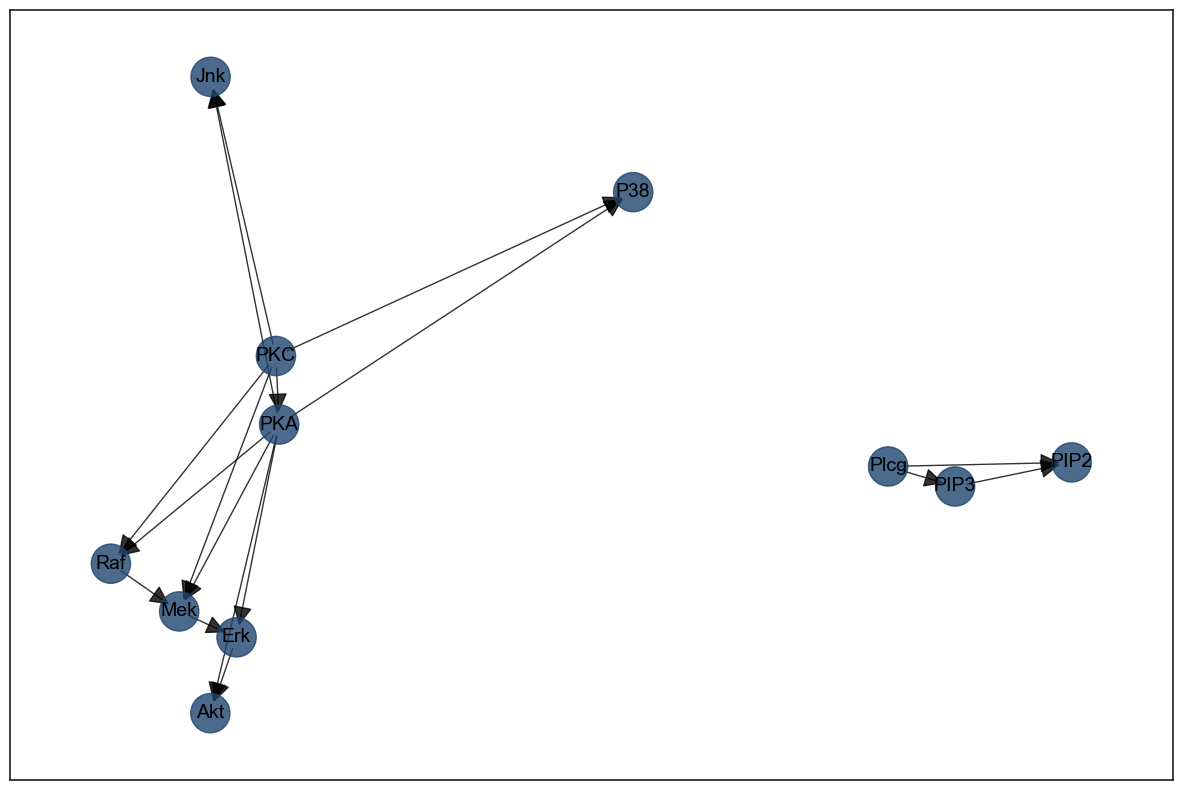

In [3]:
# loading data from bin file and preprocessing
model = bn.import_DAG(bif_file)
G = bn.plot(model)
df_dataset = bn.sampling(model, n=7000)  #returns a pandas datafram

In [4]:
df_dataset.loc[df_dataset['Raf']==2, "Raf"] = 1

In [5]:
df_dataset

,Erk,Akt,PKA,Mek,Jnk,PKC,Raf,P38,PIP3,PIP2,Plcg
0,1,0,1,1,0,0,1,1,1,0,0
1,1,0,1,1,1,1,1,0,0,0,0
2,1,0,1,1,0,1,1,0,2,0,0
3,0,0,0,0,2,0,1,2,1,0,0
4,2,1,2,1,0,1,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6995,1,0,1,0,1,1,0,1,1,2,2
6996,1,0,1,0,1,0,1,0,0,0,0
6997,2,1,1,0,0,0,1,0,1,0,0
6998,1,0,2,0,0,0,0,0,0,0,2


In [6]:
# drop pkc
drop = ['PKC']
selected_col = [i for i in df_dataset.columns if i not in drop]

pka_0= df_dataset[df_dataset['Raf']==0]
pka_0 = pka_0[selected_col]
path = "tr_data_graph.csv"
pka_0.to_csv(path, index=False)

pka_1= df_dataset[df_dataset['Raf']==1]
pka_1 = pka_1[selected_col]
path = "te_data_graph.csv"
pka_1.to_csv(path, index=False)

In [7]:
pka_0.shape

(3632, 10)

In [8]:
pka_1.shape

(3368, 10)

In [9]:
Y_col = [target]
X_col = [i for i in selected_col if i not in Y_col]

# ready the training data with respect to ith graph
df = pd.read_csv("tr_data_graph.csv")
X_train = df[X_col]  # get the features
y_train = df[Y_col]  # get the target
# Add the data to csv files
X_train, X_validate, y_train, y_validate =  train_test_split(X_train, y_train, test_size=0.3)
X_train_copy = X_train.copy()
X_train_copy[target] = y_train
X_train_copy.to_csv("splitted_tr_data_graph.csv")


X_validate.to_csv("X_validate_data.csv")
y_train.to_csv("y_train.csv", index = False)

df_test = pd.read_csv("te_data_graph.csv")
X_test  = df_test[X_col] # get the features
y_test = df_test[Y_col] # get the target
X_test.to_csv("X_test.csv", index = False)
y_test.to_csv("y_test.csv", index = False)

lb = preprocessing.LabelBinarizer()
lb.fit(y_train)
y_train_binarized = lb.transform(y_train)
y_test_binarized = lb.transform(y_test)
y_validate_binarized = lb.transform(y_validate)




In [10]:
g = GraphModel()
g.bn_with_latent_as_observed_without_S = sach_bn
g.latent_spec = latent_spec
g.conf_child = conf_children
g.latent_conf = latent_conf 
g.bn_without_latent = g.removeLatent(sach_bn, conf_children)
g.target = target

# construct the bn without u by changing every bidirected edge to directed edge 
g.create_bn_without_latent()

# learn the cpt
g.learnCPT("splitted_tr_data_graph.csv")

# Add a selection variable
g.chS = [chS]
g.s_name_list = ["S"]
bn_with_S = gum.BayesNet(g.bn_without_latent)
bn_with_S.add("S", 2)
bn_with_S.addArc("S", chS)
g.bn_with_S_and_without_latent = bn_with_S

if g.added_edges_tuple:
    g.remove_added_directed_edges_from_bn_without_latent()

# convert bn to causal models
g.convertBayesNetToCausalModel()

# STEP 8: output the graphs for reference
gumimage.export(g.cm_with_S, "sachs_causal_graph.png")

In [12]:
from sklearn.metrics import f1_score

# fit all estimators with training data
time_restriction = 120
id4ip = ID4IP(g)
id4ip.fit(X_validate, y_validate, zero_one_loss, time_restriction)
id4ip_res = id4ip.predict(X_test)
id4ip_score = f1_score(y_test[target].tolist(), id4ip_res[target].tolist(), average='micro')
print("ID4IP:{}".format(id4ip_score ))

gse = GraphSurgeryClassifier(g)
gse.fit(X_validate, y_validate, zero_one_loss, time_restriction)
gse_res = gse.predict(X_test)
gse_score = f1_score(y_test[target].tolist(), gse_res[target].tolist(), average='micro')
print("GSE:{}".format(gse_score))

# skilled model
model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
model.fit(X_train[["PIP3", "PIP2", "Plcg"]], y_train)
logit_pred = model.predict(X_test[["PIP3", "PIP2", "Plcg"]])
logit_score = f1_score(y_test, logit_pred, average='micro')
print("Logistic regression:")
print(logit_score)



Updated!
Intervention_set:['PKA', 'Erk']
Conditioning_set:[]
Training Loss:0.18440366972477065
final query:P(Akt|do(['PKA', 'Erk']), [])
ID4IP's corresponding training loss: 0.18440366972477065
ID4IP:0.8016627078384798
Updated!
Intervention_set:['Mek']
Conditioning_set:[]
Training Loss:0.3330275229357798
Updated!
Intervention_set:['Mek']
Conditioning_set:['P38']
Training Loss:0.3321100917431193
Updated!
Intervention_set:['Mek']
Conditioning_set:['PKA']
Training Loss:0.3256880733944954
Updated!
Intervention_set:['Mek']
Conditioning_set:['Erk']
Training Loss:0.1889908256880734
Updated!
Intervention_set:['Mek']
Conditioning_set:['PKA', 'Erk']
Training Loss:0.18440366972477065
final query:P(Akt|do(['Mek']), ['PKA', 'Erk'])
GSE's corresponding training loss: 0.18440366972477065
GSE:0.8016627078384798
Logistic regression:
0.5264251781472684
